In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import pandas as pd
import os
import gc
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
import itertools
import cv2
from PIL import Image
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
import keras.utils
from tensorflow.keras import utils as np_utils
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
#from keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.metrics import classification_report
from collections import defaultdict
import sklearn.metrics as metrics
from PIL import Image
from tensorflow.keras.applications import   Xception ,InceptionV3 ,DenseNet121,VGG19, VGG16,ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
base_skin_dir = os.path.join('..', 'E:/code')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
data = pd.read_csv(os.path.join(base_skin_dir, 'E:/code/HAM10000_metadata.csv'))

# Creating New Columns for better readability

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,E:/code\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,E:/code\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,E:/code\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,E:/code\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,E:/code\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


<Axes: >

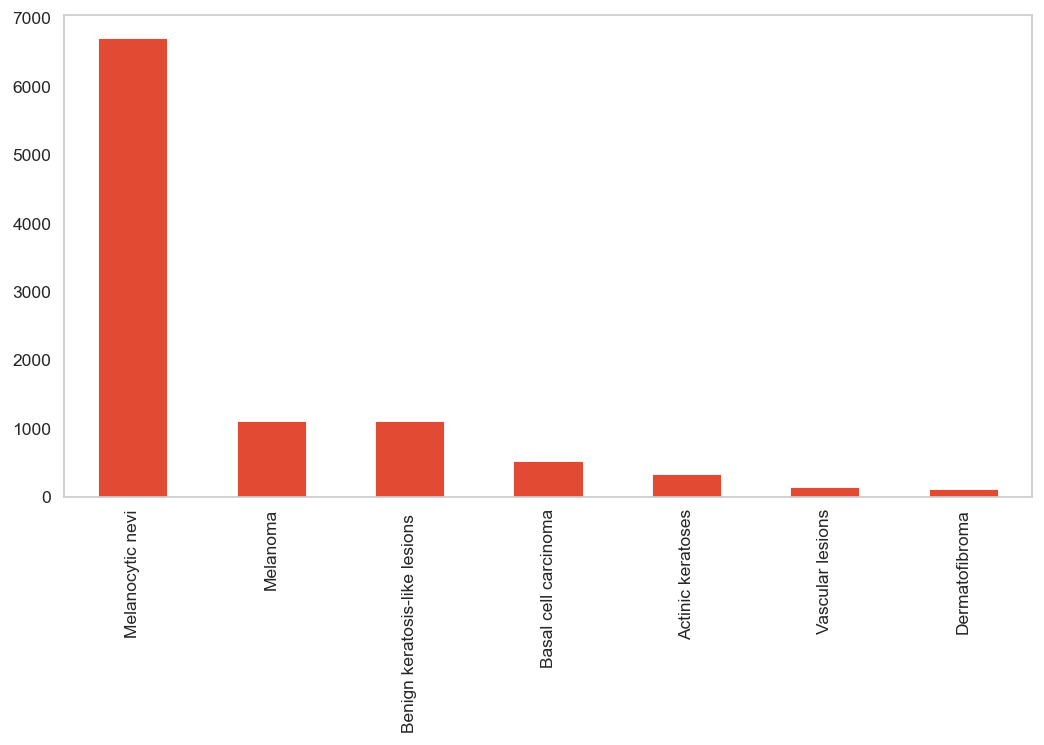

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [6]:
print(data['cell_type'].value_counts())

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


In [7]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=1500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

In [8]:
def load_img_data(size, df, balanced=False):
    #first we should normalize the image from 0-255 to 0-1
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [9]:
imgs, target   = load_img_data(128, data, balanced=False)

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [05:10<00:00, 32.29it/s]


(10015, 128, 128, 3)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=.30)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)



train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]
num_classes=7
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (9514, 128, 128, 3)
y_train shape: (9514, 7)
x_test shape: (3005, 128, 128, 3)
y_test shape: (3005, 7)
9514 train samples
3005 test samples


In [11]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.0, # mel 
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [12]:
from itertools import chain
all_labels = np.unique(list(chain(*data['dx'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (7): ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [13]:
EPOCHS = 20
BATCH_SIZE = 64
INP_SIZE = [128,128,3]

In [14]:
classes=[
    "Actinic keratoses", 
    "Basal cell carcinoma", 
    "Benign keratosis-like lesions", 
    "Dermatofibroma", 
    "Melanoma", 
    "Melanocytic nevi", 
    "Vascular lesions"
]

In [15]:
# Function for plotting the metrics
def plot_metrices(model,results_path):
    
    plt.figure(figsize=(4,4))
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')
    pred = model.predict(x_test, batch_size = BATCH_SIZE)
    pred = np.argmax(pred, axis = 1)
    Y_pred_classes = pred
    cm = confusion_matrix(y_test.argmax(axis = 1), pred)
    classes=["Actinic keratoses", "Basal cell carcinoma", "Benign keratosis-like lesions", "Dermatofibroma", "Melanoma", "Melanocytic nevi", "Vascular lesions"]
    sns.heatmap(cm, annot = True, xticklabels = all_labels, yticklabels = all_labels, annot_kws={'size':10}, fmt='d', cmap='YlGnBu')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(results_path )
    plt.show
    
    rounded_labels=  y_test.argmax(axis = 1)
    
    print(classification_report(y_test.argmax(axis = 1), pred))
    score = model.evaluate(x_train,y_train , verbose=1)
    
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print('Test accuracy:', score[1])
    print("Average Sensitivity: {:.4f}".format(sensitivity))
    print("Average Specificity: {:.4f}".format(specificity))
    print("F1 Score: ", f1_score(rounded_labels, Y_pred_classes, average="macro"))
    print("Precision Score: ", precision_score(rounded_labels, Y_pred_classes, average="macro"))
    print("Recall Score: ", recall_score(rounded_labels, Y_pred_classes, average="macro")) 

In [16]:
# Function for displaying training and validation accuracy and loss
def display_history(history_,results_path):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    fig.savefig(" loss")

    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    fig.savefig(results_path )

In [17]:
# PLOT ROC for ALL CLASSES
def display_ROC(model,results_path):
    predictions = model.predict(x_test, batch_size=32)

    from itertools import chain
    all_labels = np.unique(list(chain(*data['dx'].map(lambda x: x.split('|')).tolist())))
    all_labels = [x for x in all_labels if len(x)>0]
    print('All Labels ({}): {}'.format(len(all_labels), all_labels))
    for c_label in all_labels:
        if len(c_label)>1: # leave out empty labels
            data[c_label] = data['dx'].map(lambda finding: 1.0 if c_label in finding else 0)
    data.sample(3)

    from sklearn.metrics import roc_curve, auc
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), predictions[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    #AUC_Score = roc_auc_score(y_test[:,idx].astype(int), predictions[:,idx])
    #print("AUC_Score",AUC_Score)
#c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.title('ROC for Skin Cancer classes ')
    c_ax.legend(loc="lower right")
    fig.savefig(results_path )

    from sklearn.metrics import roc_curve, roc_auc_score

    auc_roc2 = roc_auc_score(y_test, predictions)

    #print("auc_ROC2 for all calsses",auc_roc2)

In [18]:
def display_Confusion(model,results_path):
# Confusion Matrix
    plt.figure(figsize=(4,4))
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')  
    pred = model.predict(x_test, batch_size = 64)
    pred = np.argmax(pred, axis = 1)
    cm = confusion_matrix(y_test.argmax(axis = 1), pred)
    sns.heatmap(cm, annot = True, xticklabels = all_labels, yticklabels = all_labels, annot_kws={'size':10}, fmt="d", cmap='Blues',linewidths=1)
    #results_path = 'CM for model0.png'
#print(results_path)
    plt.savefig(results_path, dpi=400)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    #print(cm)
    return cm

In [19]:
def plot_Normalized_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
def generate_pretrained_model(model_name):
    if model_name == 'Xception':
        basemodel = Xception(
        include_top = False,
        weights = 'imagenet',input_shape=INP_SIZE)
        basemodel.trainable= True
        model = tf.keras.Sequential([
            basemodel,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax')
    ])
     
    elif model_name == 'ResNet50':
        basemodel = ResNet50(
        include_top = False,
        weights = 'imagenet',input_shape=INP_SIZE)
        basemodel.trainable= True 
        model = tf.keras.Sequential([
            basemodel,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax') ])
        
    elif model_name == 'DenseNet121':
        basemodel = DenseNet121(
        include_top = False,
        weights = 'imagenet',input_shape=INP_SIZE)
        basemodel.trainable= True
        model = tf.keras.Sequential([
            basemodel,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax') ])
        
    elif model_name == 'InceptionV3':
        basemodel = InceptionV3(
        include_top = False,
        weights = 'imagenet',input_shape=INP_SIZE)
        basemodel.trainable= True
        model = tf.keras.Sequential([
            basemodel,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax') ])

    elif model_name == 'VGG16':
        basemodel = VGG16(
        include_top = False,
        weights = 'imagenet',input_shape=INP_SIZE)
        basemodel.trainable= True
        model = tf.keras.Sequential([
            basemodel,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax') ])\
        
    elif model_name == 'VGG19':
        basemodel = VGG19(
        include_top = False,
        weights = 'imagenet',input_shape=INP_SIZE)
        basemodel.trainable= True
        model = tf.keras.Sequential([
            basemodel,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax') ])
 
    else:
        model = None
        print('Invalid Choice!')
    
    return model

In [21]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=10, verbose=1, factor=.5, min_lr=0.00001)

In [22]:
def scheduler(epoch,lr):
    if epoch<8:
        return lr
    else:
        return lr*0.9
callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

In [23]:
 # Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "model0.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_acc", mode="max", save_best_only=True, verbose=1)

In [24]:
model1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

model1.fit(x_train)

In [25]:
model_name = 'DenseNet121'
model1=generate_pretrained_model(model_name)
tf.keras.utils.plot_model(model1)
model1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=1e-4), metrics=["accuracy"])
history1 = model1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, class_weight=class_weights, callbacks=[checkpoint],validation_split=0.2)

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 0.7668 - accuracy: 0.7282WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 935s 8s/step - loss: 0.7668 - accuracy: 0.7282 - val_loss: 3.1977 - val_accuracy: 0.4829
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.7845WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 919s 8s/step - loss: 0.5746 - accuracy: 0.7845 - val_loss: 1.0822 - val_accuracy: 0.6947
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8205WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 922s 8s/step - loss: 0.4796 - accuracy: 0.8205 - val_loss: 0.7845 - val_accuracy: 0.7457
Epoch 4/10
119/119 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8513WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 920s 8s/step - loss: 0.4138 - accuracy: 0.8513 - val_loss: 0.7484 - val_accuracy: 0.7535
Epoch 5/10
119/119 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8694WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 920s 8s/step - loss: 0.3448 - accuracy: 0.8694 - val_loss: 1.1040 - val_accuracy: 0.7068
Epoch 6/10
119/119 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.8900WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 924s 8s/step - loss: 0.3011 - accuracy: 0.8900 - val_loss: 0.9859 - val_accuracy: 0.7388
Epoch 7/10
119/119 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9029WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 920s 8s/step - loss: 0.2645 - accuracy: 0.9029 - val_loss: 1.6381 - val_accuracy: 0.6605
Epoch 8/10
119/119 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9171WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 925s 8s/step - loss: 0.2171 - accuracy: 0.9171 - val_loss: 0.9189 - val_accuracy: 0.7572
Epoch 9/10
119/119 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9248WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 934s 8s/step - loss: 0.2002 - accuracy: 0.9248 - val_loss: 1.3411 - val_accuracy: 0.7094
Epoch 10/10
119/119 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9430WARNING:tensorflow:Can save best model only with val_acc available, skipping.


119/119 [==============================] - 923s 8s/step - loss: 0.1628 - accuracy: 0.9430 - val_loss: 1.5867 - val_accuracy: 0.7105


94/94 [==============================] - 86s 918ms/step
All Labels (7): ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
47/47 [==============================] - 81s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.02      0.04       108
           1       0.66      0.44      0.53       135
           2       0.66      0.15      0.24       350
           3       0.48      0.38      0.42        29
           4       0.75      1.00      0.86      2048
           5       0.97      0.10      0.19       293
           6       0.71      0.93      0.80        42

    accuracy                           0.74      3005
   macro avg       0.75      0.43      0.44      3005
weighted avg       0.76      0.74      0.67      3005

298/298 [==============================] - 276s 926ms/step - loss: 1.2613 - accuracy: 0.7350
Test accuracy: 0.7350220680236816
Average Sensitivity: 0.0833
Average Specificity: 1.0000
F1 Score:  0.438622492447396
Precision Score

0

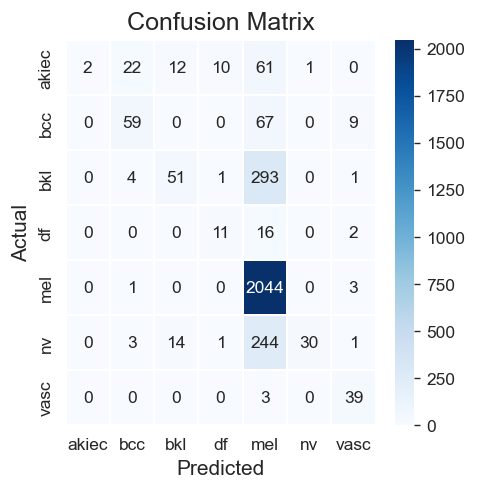

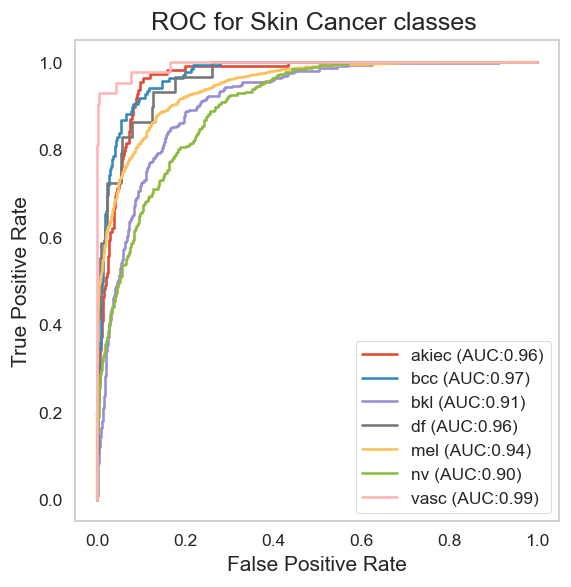

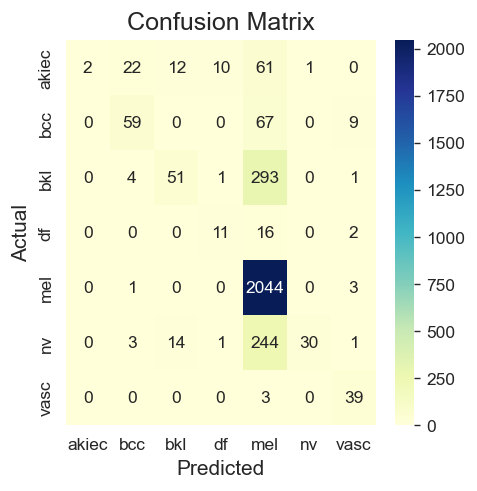

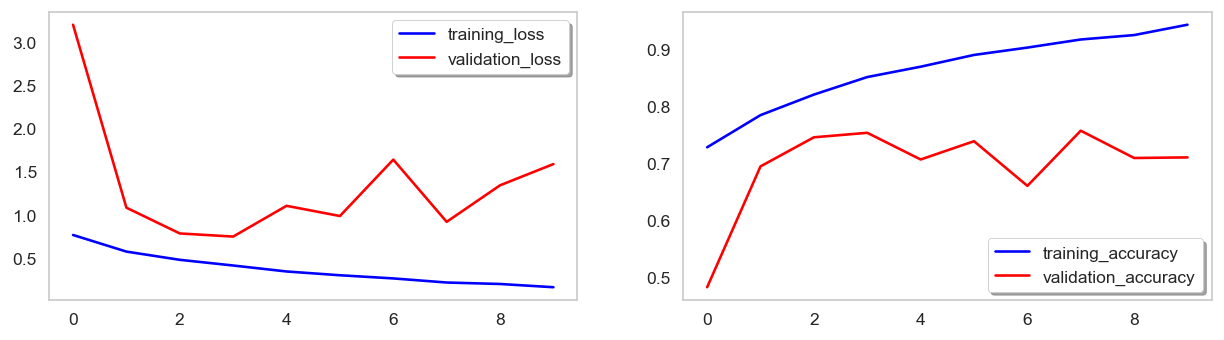

In [26]:
results_path="Resnet50nConfusion.Png"
display_Confusion(model1,results_path)
results_path="Resnet50_ROC.Png"
display_ROC(model1,results_path)
results_path="Resnet50_Result.Png"
plot_metrices(model1,results_path)
results_path="Resnet50Accuracy.Png"
display_history(history1,results_path)
gc.collect()
del model1, history1
gc.collect()